Does polling converge under certain condition?
In other words, if many polls are done, will the poll converge to some vector


First, we will analyze the difference in portion of strategic votes

In [6]:
import pandas as pd
import numpy as np

df =  pd.read_csv("converge-portion-of-strategic-vote.csv")
parse_vectors = lambda f: f.apply(lambda array: np.fromstring(array[1:-1], sep = ' ', dtype = float)) 
nth_item = lambda f, i: f.apply(lambda x: float(x[i]))

# Remove tick zero data
df = df[df["Tick"] != 0]
df = df[df["Utility Distribution"] == "Normal mean = 0"]

df["Poll"] = parse_vectors(df["Poll"])
df["Total Utility Gain"] = parse_vectors(df["Total Utility Gain"])

# Group by runs
run_groups = df.groupby(by = ["Run Number"])

# sorting should not be necessary yet
# run_groups = run_groups.apply(lambda x: x.sort_values(by = "Tick"))

What do we want to show with this data?
What is the relationship with the Standard Deviation of the poll vector, and the Portion of Strategic votes?

First, find the standard deviations of every run

In [7]:
# Define functions, for readability in the loop
ticks = max(df["Tick"])
# Finds the mean vector
from operator import add
def find_mean(group):
    mean_vector = [0] * len(group["Poll"].head(1).array[0])
    for vector in group["Poll"]:
        mean_vector = list(map(add, mean_vector, vector))
    for i in range(len(mean_vector)):
        mean_vector[i] = mean_vector[i] / ticks
    return mean_vector
# Finds total Standard deviation
def find_stdev(group):
    mean = find_mean(group)
    dev_sum = 0
    for index, row in group.iterrows():
        dev = 0
        for i in range(row["Poll"].size):
            dev += pow(row["Poll"][i] - mean[i], 2)
        dev_sum += dev
    result = pow(dev_sum / ticks,.5)
    return result
    

# Iterate through all groups of runs and calculate the stdev and mean
st_dev_runs = pd.DataFrame(columns = ["Run Number","SVP", "Standard Deviation", "Mean Vector"])
for name, group in run_groups:
    st_dev_runs = st_dev_runs.append(pd.Series(data = {
        "Run Number": int(group["Run Number"].head(1).array[0]),
        "SVP": (group["Strategic Vote Portion"].head(1).array[0]),
        "Standard Deviation": find_stdev(group),
        "Mean Vector": find_mean(group)
    }), ignore_index=True)


In [8]:
svp_groups = st_dev_runs.groupby(by = ["SVP"])

In [9]:
import matplotlib.pyplot as plt

svp_list = st_dev_runs["SVP"].drop_duplicates().array
stdev_lists = []
# Make the box plots
for name, group in svp_groups:
    stdev_lists.append(group["Standard Deviation"].array)
fig, ax = plt.subplots()
ax.boxplot(stdev_lists, showfliers = True, labels = svp_list)
plt.grid()
plt.xlabel("Strategic Portion of Vote")
plt.ylabel("Standard Deviation of the poll vector")
plt.show()

<Figure size 640x480 with 1 Axes>

SPV = .1 is giving illegible results, redo it only for SPV - .1

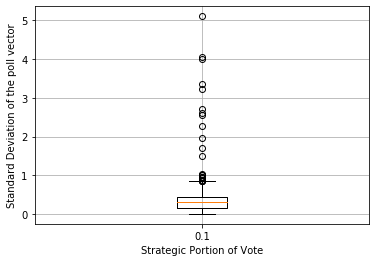

In [10]:
current_group = st_dev_runs[st_dev_runs["SVP"] == .1]
plt.boxplot([current_group["Standard Deviation"]], showfliers = True, labels = [.1])
plt.grid()
plt.xlabel("Strategic Portion of Vote")
plt.ylabel("Standard Deviation of the poll vector")
plt.show()


Obviously, if the SPV is higher, then the Standard Deviation will be higher.
Are any of these elections with higher SPV converging?

In [11]:
# Set target svp
svp = .1

"""
Params: 
polling_vectors: df with run number and poll vector
mean_vector: df with run number and mean

return:
polling_vectors, but with another column concatenated with the distance from the mean 
"""

def calculate_distance_from_mean(polling_vectors, mean_vector):
    result = pd.concat([polling_vectors[polling_vectors["Strategic Vote Portion"] == svp], pd.DataFrame(columns = ["Distance from Mean"])], sort = False)
    for index, row in result.iterrows():
        mean = mean_vector[mean_vector["Run Number"] == row["Run Number"]]["Mean Vector"].head(1).array[0]
        poll = row["Poll"]
        distance = 0
        for i in range(len(mean)):
            distance += pow(mean[i] - poll[i], 2) 
        distance = pow(distance, .5)
        result.loc[index, "Distance from Mean"] = distance
    return result
svp_filter_df = calculate_distance_from_mean(df[df["Strategic Vote Portion"] == svp], st_dev_runs[st_dev_runs["SVP"] == svp])
svp_filter_df = svp_filter_df[svp_filter_df["Run Number"].apply(lambda x: bool(x))]

In [12]:
svp_filter_df = svp_filter_df.sort_values("Distance from Mean")
svp_filter_df["Distance from Mean"] = svp_filter_df["Distance from Mean"].apply(lambda x: float(x))
svp_filter_df["Tick"] = svp_filter_df["Tick"].apply(lambda x: float(x))

This graph doesn't really tell us anything, there doesn't seem to be a correlation between distance from mean and number of ticks.

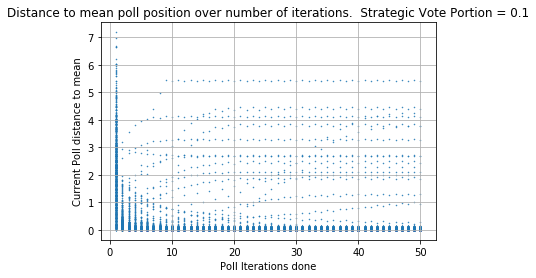

In [13]:
svp_filter_df.plot.scatter("Tick", "Distance from Mean", s = .25)
plt.grid()
plt.xlabel("Poll Iterations done")
plt.ylabel("Current Poll distance to mean")
plt.title("Distance to mean poll position over number of iterations.  Strategic Vote Portion = "+ str(svp))
plt.show()

But if we look at only one of the runs,

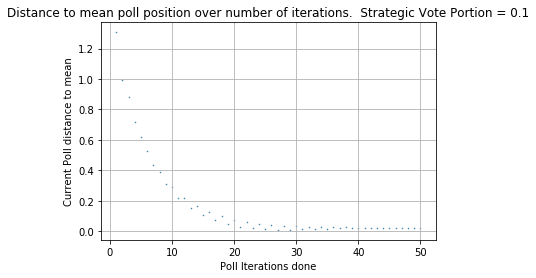

In [14]:
random_run = svp_filter_df.sample(n=1)
random_run = svp_filter_df[svp_filter_df["Run Number"] == random_run.iat[0, 0]].sort_values("Tick")
random_run.plot.scatter("Tick", "Distance from Mean", s = .25)
plt.grid()
plt.xlabel("Poll Iterations done")
plt.ylabel("Current Poll distance to mean")
plt.title("Distance to mean poll position over number of iterations.  Strategic Vote Portion = "+ str(svp))
plt.show()